In [1]:
%matplotlib inline
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import pandas as pd
import corner
import astropy
import astropy.units as u
#import numba


In [2]:
columns=['name','redshift','distance_mod','DM_err','SN_prob']
rawdat=pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\s',names=columns, header=5, engine='python')

In [3]:
data=np.sort(rawdat.T, axis=0)
zs = rawdat.redshift
mm = rawdat.distance_mod
dm = rawdat.DM_err

In [4]:
np.mean(zs)

0.3622064306038266

In [6]:
np.std(zs)

0.3270591763032889

In [5]:
np.mean(mm)

40.03658148802193

In [7]:
np.std(mm)

3.1896553031584083

In [8]:
np.mean(dm)

0.22295302619411

In [9]:
np.std(dm)

0.12601239642034218

In [4]:
from astropy.cosmology import wCDM


In [5]:
#because the equation of state must be constant
def w(z) :
    wz=w0
    return wz

In [6]:
#@numba.jit
def DM(z,H0,Om,Ode,w0):
    cosmo = wCDM(H0=H0* u.km / u.s / u.Mpc, Om0=Om,Ode0=Ode,w0=w0)
    DL=cosmo.luminosity_distance(z)
    mag=5*np.log10((DL/(10*u.pc)).decompose())
    #wz=cosmo.w(z)
    return mag

In [7]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [8]:
p = lmfit.Parameters()
p.add_many(('Om',0.3,True,0.,2.),('H0',70.0,True,50.,100.),('Ode',0.7,True,0.,2.),('w0',-1.0,True,-1.5,0.5))

def residual(p):
    v = p.valuesdict()
    return (DM(zs,v['H0'],v['Om'],v['Ode'],v['w0'])-mm)/dm

In [9]:
print p

Parameters([('Om', <Parameter 'Om', 0.3, bounds=[0.0:2.0]>), ('H0', <Parameter 'H0', 70.0, bounds=[50.0:100.0]>), ('Ode', <Parameter 'Ode', 0.7, bounds=[0.0:2.0]>), ('w0', <Parameter 'w0', -1.0, bounds=[-1.5:0.5]>)])


In [10]:
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 345
    # data points      = 579
    # variables        = 4
    chi-square         = 561.852083
    reduced chi-square = 0.97713406
    Akaike info crit   = -9.40697460
    Bayesian info crit = 8.03823531
[[Variables]]
    Om:   0.27602461 (init = 0.3)
    H0:   70.0378701 (init = 70)
    Ode:  0.59542581 (init = 0.7)
    w0:  -1.16753880 (init = -1)


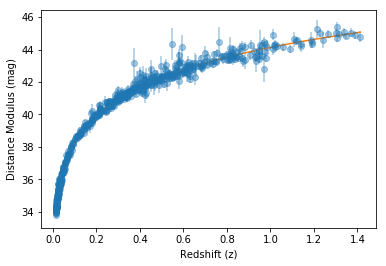

In [12]:
s = (zs.sort_values()).index
plt.errorbar(zs[s],mm[s],yerr=dm[s],fmt='o',alpha=0.4)
bestOm = mi.params.valuesdict()['Om']
bestH0 = mi.params.valuesdict()['H0']
bestOde= mi.params.valuesdict()['Ode']
bestw0 = mi.params.valuesdict()['w0']
plt.plot(zs[s],DM(zs[s],bestH0,bestOm,bestOde,bestw0))
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mag)')
lmfit.report_fit(mi)

In [13]:
#%%prun -r -T "resultsw2"
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1500, thin=1,
                         params=p, is_weighted=True)

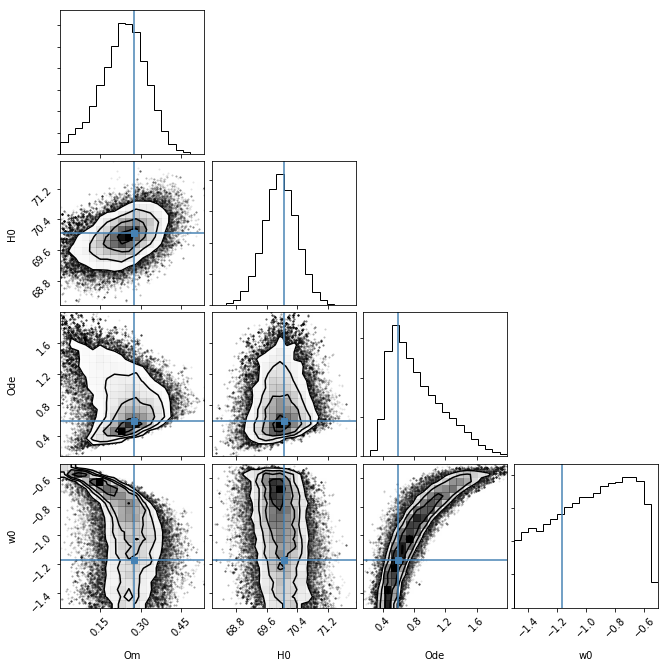

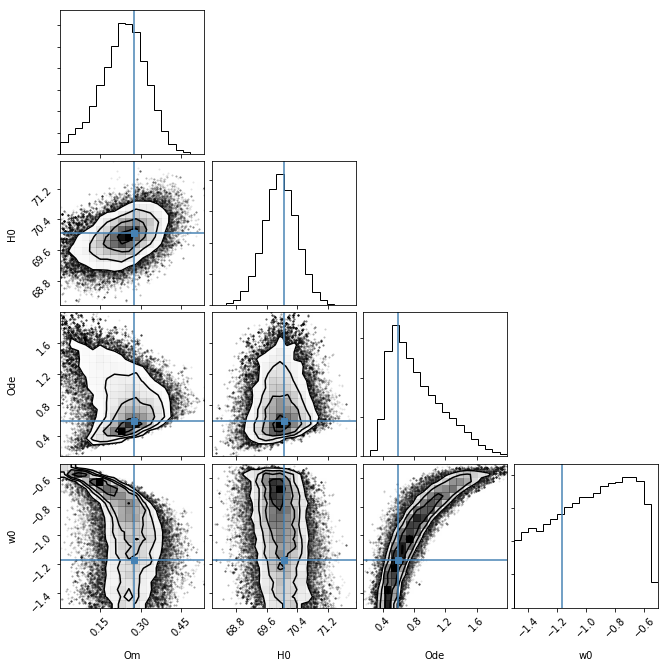

In [14]:
corner.corner(res.flatchain,labels=mi.var_names, truths=list(mi.params.valuesdict().values()))
